### Information for all active regions and their properties 
Data were gathered from [SpaceWeatherLive](https://www.spaceweatherlive.com/en/archive/) and contains information about active regions at each day from 1996-06-07 till 2017-12-28

In [1]:
import numpy as np   
import pandas as pd 
import pickle
import drms
from astropy.time import Time
import urllib, requests
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
c = drms.Client()

In [2]:
sunspots = pd.read_pickle('sunspot_1996_2017.pkl')
sunspots.tail(5)

,,number_of_ss,size,class,location,magn_class
date,region,,,,,
2017-12-24,12692,12,90,DAO,N18E03,B
2017-12-25,12692,12,160,EAI,N18W09,B
2017-12-26,12692,7,100,EAO,N18W23,B
2017-12-27,12692,4,30,CRO,N18W35,B
2017-12-28,12692,1,10,AXX,N17W46,A


In [3]:
sunspots_byregion = sunspots.swaplevel(0, 1)
sunspots_byregion.tail()

number_of_ss size class location magn_class
region date                                                  
12692  2017-12-24           12   90   DAO   N18E03          B
       2017-12-25           12  160   EAI   N18W09          B
       2017-12-26            7  100   EAO   N18W23          B
       2017-12-27            4   30   CRO   N18W35          B
       2017-12-28            1   10   AXX   N17W46          A

In [4]:
#Choose only HMI data from the table
sunspotsHMI = sunspots.loc['2010-05-01':'2017-12-28']
sunspotsHMI.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11929 entries, (2010-05-01 00:00:00, 11064) to (2017-12-28 00:00:00, 12692)
Data columns (total 5 columns):
number_of_ss    11929 non-null object
size            11929 non-null object
class           11929 non-null object
location        11929 non-null object
magn_class      11929 non-null object
dtypes: object(5)
memory usage: 602.2+ KB


In [5]:
McClassByRegion = sunspotsHMI['class'].groupby(level = 'region').value_counts()

In [6]:
McClassByRegion.head(4)

region  class
11063   BXO      3
11064   AXX      1
        BXO      1
        CRO      1
Name: class, dtype: int64

### Download magnetogram from JSOC database by AR number

In [7]:
#List with harp - noaa
df_noaa_harp= pd.read_csv('http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt',sep=' ')
df_noaa_harp.head(3)

,HARPNUM,NOAA_ARS
0,1,11067
1,2,11064
2,6,11065


In [8]:
NOAA = 12673
groupNOAA = sunspotsHMI.query('region =='+ str(NOAA))
print(groupNOAA)
date_num =  list(groupNOAA.index.get_values())

                  number_of_ss  size class location magn_class
date       region                                             
2017-08-30 12673             1    70   HSX   S08E62          A
2017-08-31 12673             1    70   HSX   S08E48          A
2017-09-01 12673             1    80   HSX   S08E36          A
2017-09-02 12673             1    80   HSX   S08E23          A
2017-09-03 12673             4    60   CSO   S10E09          B
2017-09-04 12673            12   130   DSC   S10W02        BGD
2017-09-05 12673            28   680   DKC   S10W16        BGD
2017-09-06 12673            33   880   DKC   S10W30        BGD
2017-09-07 12673            24   960   EKC   S10W43        BGD
2017-09-08 12673            21  1000   EKC   S10W57        BGD
2017-09-09 12673            19  1060   DKC   S09W70        BGD
2017-09-10 12673             8   530   DKC   S09W83        BGD


In [17]:
#take first record
date, noaa = date_num[7]
ta = Time(date, format='datetime', scale='tai')
date_tai = ta.value.strftime('[%Y.%m.%d_%H:%M:%S_TAI]') 

In [18]:
def get_harp_by_noaa(noaa, df_noaa_harp = None ):
    """
    get harp region by noaa number
    noaa = string with AR Number '11158' 
    """
    if df_noaa_harp is None:
        #import from jsoc table correspondense
        df_noaa_harp= pd.read_csv('http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt',sep=' ')
        
    df_harp = df_noaa_harp.loc[df_noaa_harp['NOAA_ARS'].str.contains(str(noaa))]
    m  = df_harp.shape[0]
    harp = 'MULT'
    if m==0 :
        harp = 'NOT'
    else:
        for ind, row in df_harp.iterrows():
            if row['NOAA_ARS'].find(',') == -1:
                harp = int(row['HARPNUM']) 
    
    return harp  

In [19]:
harp = get_harp_by_noaa(NOAA, df_noaa_harp = df_noaa_harp)
print("HARP number from JSOC database for NOAA {} is {}".format(NOAA,harp))

HARP number from JSOC database for NOAA 12673 is 7115


In [20]:
ds = 'hmi.sharp_720s[{}]{}'.format(harp, date_tai)
k,s = c.query(ds, key='T_REC, NOAA_AR, NOAA_NUM, HARPNUM', seg = 'magnetogram')

In [21]:
if k.shape[0]>0 and 'fits' in s['magnetogram'][0]:
    url = 'http://jsoc.stanford.edu' + s['magnetogram'][0]
    print('Url found', url)
    filename ='hmi.sharp_720s.{}.'.format(harp) +  date.strftime('%Y%m%d_%H%M%S_TAI.magnetogram.fits')
    print("Download data and save to path", filename)
    file_name=urllib.request.urlretrieve(url,filename)
else: 
    print('No fits with this request')

Url found http://jsoc.stanford.edu/SUM88/D979015258/S00000/magnetogram.fits
Download data and save to path hmi.sharp_720s.7115.20170906_000000_TAI.magnetogram.fits


In [22]:
def show_fits(filepath):
    #Потом из директории загружаем и делаем, что хотим
    hdulist = fits.open(filepath)
    hdulist[1].verify("silentfix")
    fits_data1 =  hdulist[1].data
    plt.imshow(fits_data1,cmap = plt.get_cmap('gray')); plt.title(filepath)

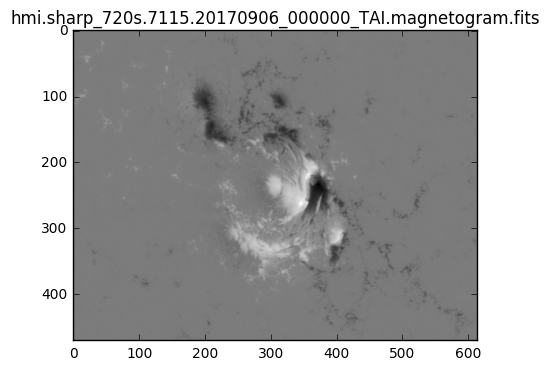

In [23]:
show_fits(filename)